# **Wine Recommender System Modeling**

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans as kmeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
wine = pd.read_csv('/content/gdrive/MyDrive/Drexel/winemag-data-130k-v2.csv')  #AS Path
#wine = pd.read_csv('/content/gdrive/MyDrive/winemag-data-130k-v2.csv') #SN path

## *Data Cleaning and Preprocessing*

### General Cleaning

Dropping Irrelevant data

In [4]:
#Drop duplicated reviews
wine = wine.drop_duplicates(subset=['taster_name', 'title'])

#Drop two irrelevant columns
wine = wine.drop(["Unnamed: 0", "taster_twitter_handle"], axis=1)

Point Range

In [5]:
#Create point range feature
wine['point_range'] = np.where(wine['points'] > 88, "High", "Low")
wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,point_range
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,Low
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,Low
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,Low
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,Low
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,Low


Descriptions

In [6]:
#Define stop words
exclusions = set(['a','about','above','after','again','against','all','also','am','an','and','any','are',"arent",'as','at',
'be','because','been','before','being','below','between','both','but','by',
'can',"cant",'cannot','com','could',"couldnt",'did',"didnt",'do','does',"doesnt",'doing',"dont",'down','during',
'each','else','ever','few','for','from','further','get',
'had',"hadnt",'has',"hasnt",'have',"havent",'having','he',"hed","hell","hes",'hence','her','here',"heres",'hers','herself','him','himself','his','how',"hows",'however','http',
'i',"id","ill","im","ive",'if','in','into','is',"isnt",'it','its','itself','just','k',"lets",'like',
'me','more','most',"mustnt",'my','myself','no','nor','not','now',
'of','off','on','once','only','or','other','otherwise','ought','our','ours','ourselves','out','over','own',
'r','same','shall',"shant",'she',"shed","shell","shes",'should',"shouldnt",'since','so','some','such',
'than','that',"thats",'the','their','theirs','them','themselves','then','there',"theres",'therefore','these','they',"theyd","theyll","theyre","theyve",'this','those','through','to','too',
'under','until','up','very',
'was',"wasnt",'we',"wed","well","were","weve","werent",'what',"whats",'when',"whens",'where',"wheres",'which','while','who',"whos",'whom','why',"whys",'with',"wont",'would',"wouldnt",'www',
'you',"youd","youll","youre","youve",'your','yours','yourself','yourselves'])

In [7]:
import string

def clean_description(x):
    if isinstance(x, str):
        x = x.lower()
        x = x.translate(str.maketrans('', '', string.punctuation))
        x = x.split()
        final_lst = []
        for word in x:
            if word not in exclusions:
                final_lst.append(word)
        return final_lst
    else:
        return []

In [8]:
#clean the description of each wine to isolate every word
wine['description'] = wine['description'].apply(clean_description)

#check to see if description is cleaned as expected
wine[['description']].head()

,description
0,"[aromas, include, tropical, fruit, broom, brim..."
1,"[ripe, fruity, wine, smooth, still, structured..."
2,"[tart, snappy, flavors, lime, flesh, rind, dom..."
3,"[pineapple, rind, lemon, pith, orange, blossom..."
4,"[much, regular, bottling, 2012, comes, across,..."


Dropping Nulls

In [9]:
# remove rows with price of null
wine = wine.dropna(subset=['price'])

#shape should now be 118971 - 8265 = 110706
wine.shape

(110706, 13)

In [10]:
## remove rows with country of null
wine = wine.dropna(subset=['country'])

#shape should now be 110706 - 55 = 110651
wine.shape

(110651, 13)

In [11]:
## remove rows with variety of null
wine = wine.dropna(subset=['variety'])

#shape should now be 110651 - 1 = 110650
wine.shape

(110650, 13)

Cleaning Location

In [12]:
#Combine province and region_2 (for US states) to get location feature

#Create location column as duplicate of province to start
wine['location'] = wine.loc[:, 'province']

#For U.S states with region_2 we will assign this as the location
wine.loc[(wine['country']=='US') & (wine['region_2'].notnull()), 'location'] = wine['region_2']

Cleaning Price

In [13]:
#Create log transformed price column to handle the right skew
wine['transformed_price'] = np.log(wine['price'])

Cleaning Points

In [14]:
#Finally, re-scale the points column
wine['points_transformed'] = (wine['points'] - 80) * 0.5 + 1

Data before One-Hot Encoding

In [15]:
wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,point_range,location,transformed_price,points_transformed
1,Portugal,"[ripe, fruity, wine, smooth, still, structured...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,Low,Douro,2.708050,4.5
2,US,"[tart, snappy, flavors, lime, flesh, rind, dom...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,Low,Willamette Valley,2.639057,4.5
3,US,"[pineapple, rind, lemon, pith, orange, blossom...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,Low,Michigan,2.564949,4.5
4,US,"[much, regular, bottling, 2012, comes, across,...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,Low,Willamette Valley,4.174387,4.5
5,Spain,"[blackberry, raspberry, aromas, show, typical,...",Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,Low,Northern Spain,2.708050,4.5


In [16]:
wine.shape

(110650, 16)

### Cleaning for Clustering

In [18]:
wine_clus = wine[['transformed_price', 'points_transformed']]
wine_clus['variety_num'] = wine['variety'].astype('category').cat.codes
wine_clus['location_num'] = wine['location'].astype('category').cat.codes
#wine_clus['country_num'] = wine['country'].astype('category').cat.codes
wine_clus.head()


<ipython-input-18-c3a37cbe469d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine_clus['variety_num'] = wine['variety'].astype('category').cat.codes
<ipython-input-18-c3a37cbe469d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine_clus['location_num'] = wine['location'].astype('category').cat.codes


,transformed_price,points_transformed,variety_num,location_num
1,2.708050,4.5,442,110
2,2.639057,4.5,428,430
3,2.564949,4.5,471,221
4,4.174387,4.5,432,430
5,2.708050,4.5,579,268


In [ ]:
#wine_clus2 = wine_clus[['transformed_price', 'points_transformed']]
#wine_clus2.head()

,transformed_price,points_transformed
1,2.708050,4.5
2,2.639057,4.5
3,2.564949,4.5
4,4.174387,4.5
5,2.708050,4.5


In [20]:
X = wine_clus.drop(['points_transformed'], axis = 1)
y = wine_clus['points_transformed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_test = train_test_split(wine_clus, test_size = 0.2, random_state = 42)
#X_train, X_test = train_test_split(wine_clus2, test_size = 0.2, random_state = 42)
X_train.shape

(88520, 3)

In [21]:
X_test.shape

(22130, 3)

In [25]:
X_train.head()

,transformed_price,variety_num,location_num
3580,3.401197,432,430
56323,2.833213,123,47
48602,4.442651,564,221
52260,2.708050,123,344
26335,2.484907,61,36


In [26]:
X_test.head()

,transformed_price,variety_num,location_num
42988,4.007333,465,344
199,3.332205,69,338
90836,3.663562,78,68
80733,4.025352,60,36
76924,3.178054,465,338


In [27]:
y_train.head()

3580     5.5
56323    4.0
48602    3.0
52260    3.0
26335    4.0
Name: points_transformed, dtype: float64

In [28]:
y_test.head()

42988    7.5
199      6.0
90836    6.5
80733    6.0
76924    6.5
Name: points_transformed, dtype: float64

### One-Hot Encoding

One-Hot Encoding - location

In [ ]:
#wine.location.unique().size

In [ ]:
# One-Hot Encoding the location column
#locations = pd.get_dummies(wine.location, prefix = 'Location')
#locations.head()

In [ ]:
#wine2 = wine.join(locations)
#wine2.head()

One-Hot Encoding - Variety

In [ ]:
#wine.variety.unique().size

In [ ]:
# One-Hot Encoding the variety column
#varieties = pd.get_dummies(wine.variety, prefix = 'Variety')
#varieties.head()

In [ ]:
#wine2 = wine2.join(varieties)
#wine2.head()

One-Hot Encoding - Winery

In [ ]:
#wine.winery.unique().size

In [ ]:
# One-Hot Encoding the variety column
#wineries = pd.get_dummies(wine.winery, prefix = 'Winery')
#wineries.head()

In [ ]:
#wine2 = wine2.join(wineries)
#wine2.head()

## *Modeling*

### Content-Based

In [ ]:
wine2.taster_name.value_counts()

Roger Voss            18068
Michael Schachner     13762
Kerin O’Keefe          8852
Paul Gregutt           8825
Virginie Boone         8663
Matt Kettmann          5612
Joe Czerwinski         4630
Sean P. Sullivan       4410
Anna Lee C. Iijima     3969
Jim Gordon             3745
Anne Krebiehl MW       2993
Lauren Buzzeo          1581
Susan Kostrzewa        1003
Mike DeSimone           440
Jeff Jenssen            415
Alexander Peartree      381
Carrie Dykes            128
Fiona Adams              24
Christina Pickard         6
Name: taster_name, dtype: int64

In [ ]:
content_df = wine2[wine2['taster_name']=='Roger Voss']

In [ ]:
content_df = content_df.groupby(['variety', 'location']).filter(lambda x:len(x)>3)
content_df.shape

(17481, 1144)

In [ ]:
regression_df = content_df.drop(['country', 'description', 'designation', 'points', 'price', 'province', 'region_1', 'region_2', 'variety',
                         'winery', 'point_range', 'location'], axis=1)

In [ ]:
#This can be ran to remove the one-hot encoded columns populated with 0 for all records after filtering, but is not required
#Seems that when this sell IS NOT run, the model will perform better
#regression_df = regression_df.loc[:, (regression_df != 0).any(axis=0)]

In [ ]:
regression_df.shape

(17481, 1132)

In [ ]:
X = regression_df.drop(['taster_name', 'title', 'points_transformed'], axis=1)
y = regression_df['points_transformed']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
linreg = linear_model.LinearRegression()

In [ ]:
linreg.fit(X_train, y_train)

LinearRegression()

In [ ]:
lin_pred = linreg.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = mean_squared_error(y_test, lin_pred, squared=False)
print('RMSE:', rmse)

r2 = r2_score(y_test, lin_pred)
print('R-Squared:', r2)

RMSE: 1.0131847249093389
R-Squared: 0.5663491057323384


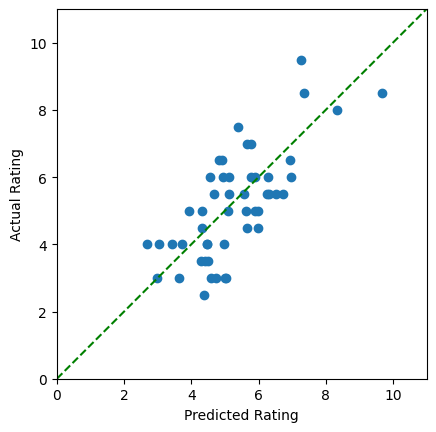

In [ ]:
plt.scatter(lin_pred[:50], y_test[:50])
plt.xlim(0, 11)
plt.ylim(0, 11)
ax = plt.gca()
ax.set_aspect('equal')
plt.ylabel('Actual Rating')
plt.xlabel('Predicted Rating')
x = np.linspace(0, 11)
#plt.plot(x, x+1, '--r')
#plt.plot(x, x-1, '--r')
plt.plot(x, x+0, '--g')
plt.show()

In [ ]:
clf_df = content_df.drop(['country', 'description', 'designation', 'points', 'price', 'province', 'region_1', 'region_2', 'variety',
                         'winery', 'points_transformed', 'location'], axis=1)

In [ ]:
clf_df.shape

(17481, 1132)

In [ ]:
clf_df.loc[clf_df['point_range']=='High', 'classifier']=1
clf_df.loc[clf_df['point_range']=='Low', 'classifier']=0

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X_logreg = clf_df.drop(['taster_name', 'title', 'point_range', 'classifier'], axis=1)
y_logreg = clf_df['classifier']

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_logreg, y_logreg, test_size=0.2)

In [ ]:
clf = LogisticRegression()

In [ ]:
clf.fit(X_train2, y_train2)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
clf_pred = clf.predict(X_test2)

              precision    recall  f1-score   support

         0.0       0.76      0.83      0.79      1792
         1.0       0.80      0.73      0.76      1705

    accuracy                           0.78      3497
   macro avg       0.78      0.78      0.78      3497
weighted avg       0.78      0.78      0.78      3497



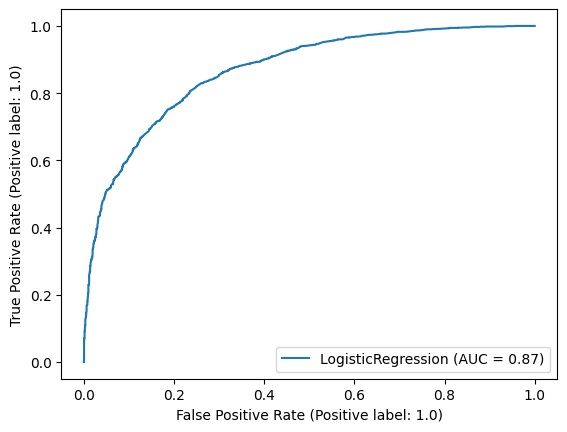

[[1479  313]
 [ 462 1243]]


In [ ]:
from sklearn import metrics

#Show the metrics for the model performance
print(metrics.classification_report(y_test2, clf_pred))

#Plot the ROC Curve
metrics.RocCurveDisplay.from_estimator(clf, X_test2, y_test2)
plt.show()

#Display the Confusion Matrix
confusion = metrics.confusion_matrix(y_test2, clf_pred)
print(confusion)

### Constraint-Based

In [ ]:
wine.shape

(110650, 16)

In [ ]:
wine3 = wine.set_index(['title'])
wine3['avg_rating'] = wine3.groupby('title')['points'].mean()

In [ ]:
wine3.head(1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,variety,winery,point_range,location,transformed_price,points_transformed,avg_rating
title,,,,,,,,,,,,,,,,
Quinta dos Avidagos 2011 Avidagos Red (Douro),Portugal,"[ripe, fruity, wine, smooth, still, structured...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,Portuguese Red,Quinta dos Avidagos,Low,Douro,2.70805,4.5,87.0


In [ ]:
def constraint_based(df):

    #get the input country
    print("Input preferred country (United States = 'US'):")
    country = input().lower()

    #get the target low price
    print("Input lowest preferred bottle price (in dollars):")
    low_price = float(input())

    #get the maximum wine price
    print("Input highest preferred bottle price (in dollars):")
    high_price = float(input())

    #get the preferred variety
    print("Input preferred wine variety (e.g. 'Pinot Noir'):")
    variety = input().lower()

    #get the preferred keyword
    print("Input relevant preferred keyword associated with other wine reviews (e.g. 'fruity'):")
    keyword = input().lower()
    keyword_mask = df['description'].apply(lambda x: True if keyword in x else False)

    #create copy of dataframe to find the related movies based on the search queries
    wines = df.copy()

    wines['country'] = wines['country'].str.lower()
    wines['variety'] = wines['variety'].str.lower()

    #filter new dataframe based on user search queries
    wines = wines[(wines['country'] == country) &
                    (wines['price'] >= low_price) &
                    (wines['price'] <= high_price) &
                    (wines['variety'] == variety) &
                    keyword_mask]

    if len(wines) > 0:

        #Return search results based on average rating
        if len(wines) <= 10:
          return wines.sort_values('avg_rating', ascending=False)

        else:
          return wines.sort_values('avg_rating', ascending=False)[:10]

    else:
        print("Your search criteria returned zero results")

In [ ]:
constraint_based(wine3)

Input preferred country (United States = 'US'):
portugal
Input lowest preferred bottle price (in dollars):
10
Input highest preferred bottle price (in dollars):
30
Input preferred wine variety (e.g. 'Pinot Noir'):
portuguese red
Input relevant preferred keyword associated with other wine reviews (e.g. 'fruity'):
smooth


,country,description,designation,points,price,province,region_1,region_2,taster_name,variety,winery,point_range,location,transformed_price,points_transformed,avg_rating
title,,,,,,,,,,,,,,,,
Luis Duarte 2012 Rapariga da Quinta Reserva Red (Alentejano),portugal,"[juicy, alicante, bouschet, shines, smooth, ri...",Rapariga da Quinta Reserva,93,26.0,Alentejano,NaN,NaN,Roger Voss,portuguese red,Luis Duarte,High,Alentejano,3.258097,7.5,93.0
Companhia das Quintas 2009 Quinta de Pancas Reserva Red (Lisboa),portugal,"[beautiful, smooth, polished, tannins, spice, ...",Quinta de Pancas Reserva,93,30.0,Lisboa,NaN,NaN,Roger Voss,portuguese red,Companhia das Quintas,High,Lisboa,3.401197,7.5,93.0
Wines & Winemakers 2009 Aguia Moura em Vinhas Velhas Reserva Red (Douro),portugal,"[smooth, impressively, rich, wine, powered, si...",Aguia Moura em Vinhas Velhas Reserva,93,18.0,Douro,NaN,NaN,Roger Voss,portuguese red,Wines & Winemakers,High,Douro,2.890372,7.5,93.0
Niepoort 2009 Redoma Red (Douro),portugal,"[smooth, rich, tannins, buried, ripe, sumptuou...",Redoma,93,30.0,Douro,NaN,NaN,Roger Voss,portuguese red,Niepoort,High,Douro,3.401197,7.5,93.0
Herdade do Esporão 2011 Esporão Reserva Red (Alentejo),portugal,"[12, months, wood, aging, powerful, wine, mana...",Esporão Reserva,93,23.0,Alentejo,NaN,NaN,Roger Voss,portuguese red,Herdade do Esporão,High,Alentejo,3.135494,7.5,93.0
Muxagat 2010 Mux Tinto Red (Douro),portugal,"[smooth, rich, selection, wood, aged, full, ri...",Mux Tinto,92,30.0,Douro,NaN,NaN,Roger Voss,portuguese red,Muxagat,High,Douro,3.401197,7.0,92.0
Real Companhia Velha 2014 Quinta dos Aciprestes Reserva Red (Douro),portugal,"[aged, year, oak, rich, smooth, densely, textu...",Quinta dos Aciprestes Reserva,92,25.0,Douro,NaN,NaN,Roger Voss,portuguese red,Real Companhia Velha,High,Douro,3.218876,7.0,92.0
Muxagat 2011 Mux Tinto Red (Douro),portugal,"[wine, black, color, barely, escapes, much, in...",Mux Tinto,92,30.0,Douro,NaN,NaN,Roger Voss,portuguese red,Muxagat,High,Douro,3.401197,7.0,92.0
Adega de Cantanhede 2010 Marquês de Marialva Grande Reserva Red (Bairrada),portugal,"[wine, rich, blend, baga, touriga, nacional, r...",Marquês de Marialva Grande Reserva,92,30.0,Bairrada,NaN,NaN,Roger Voss,portuguese red,Adega de Cantanhede,High,Bairrada,3.401197,7.0,92.0


### Clustering

#### Elbow Method - To Determine Number of Clusters

In [ ]:
distortions = []
k_values = range(1, 21)
for k in k_values:
  kmeans_model =kmeans(n_clusters = k)
  kmeans_model.fit(X_train)
  distortions.append(kmeans_model.inertia_)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

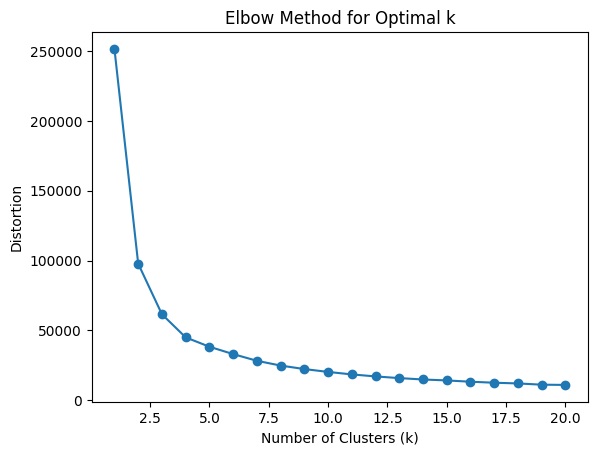

In [ ]:
plt.plot(k_values, distortions, marker = 'o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal k')
plt.show()

#### KMeans Clusters

In [ ]:
k = 4
kmeans_model = kmeans(n_clusters = k)
kmeans_model.fit(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4)

In [ ]:
cluster_centers = kmeans_model.cluster_centers_
cluster_labels = kmeans_model.labels_

In [ ]:
price_array = X_train['transformed_price'].to_numpy()
price_array

array([3.40119738, 2.83321334, 4.44265126, ..., 3.21887582, 2.99573227,
       3.91202301])

In [ ]:
points_array = X_train['points_transformed'].to_numpy()
points_array

array([5.5, 4. , 3. , ..., 3. , 4.5, 5.5])

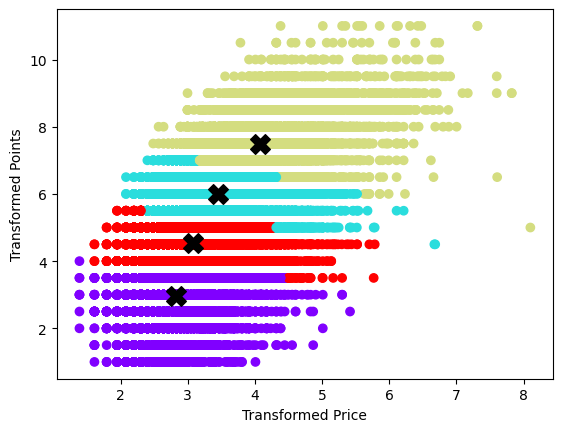

In [ ]:
plt.scatter(price_array, points_array, c = cluster_labels, cmap='rainbow')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker = 'X', s = 200, c = 'black')
plt.xlabel('Transformed Price')
plt.ylabel('Transformed Points')
plt.show()

In [ ]:
user_clusters = kmeans_model.predict(X_test)

In [ ]:
user_index = 0
user_cluster = user_clusters[user_index]

items_in_same_cluster_indices = np.where(user_clusters == user_cluster)[0]

recommended_items = items_in_same_cluster_indices